In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
# Dataset
df=pd.read_csv('./../../dataset/raw_jawa_barat.csv', parse_dates=["date"], index_col="date")
#df['daily_case'] = df['daily_case'].str.replace(',','').astype(int)

# Cut dataset to start from 1 April 2022
df = df[29:]
df.head()

,daily_case
date,
2020-04-01,20
2020-04-02,15
2020-04-03,2
2020-04-04,20
2020-04-05,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 766 entries, 2020-04-01 to 2022-05-06
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   daily_case  766 non-null    int64
dtypes: int64(1)
memory usage: 12.0 KB


In [4]:
df.shape

(766, 1)

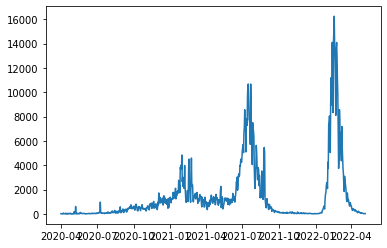

In [5]:
plt.plot(df)

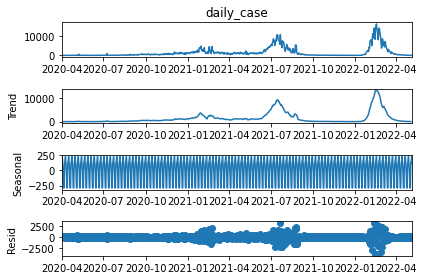

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['daily_case'])
results.plot();

In [7]:
df.shape

(766, 1)

In [8]:
# stationarity check
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [9]:
adf_test(df['daily_case'])

1. ADF :  -3.999454269905676
2. P-Value :  0.0014133715532362204
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 748
5. Critical Values :
	 1% :  -3.43912257105195
	 5% :  -2.8654117005229844
	 10% :  -2.568831705010152


In [10]:
# Split data to train and test
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

train_data=df[:train_size]
test_data=df[train_size:]

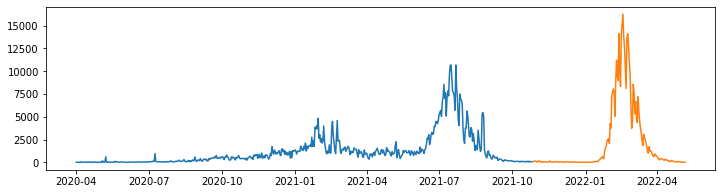

In [11]:
train_data=df[:train_size]
test_data=df[train_size:]
plt.figure(figsize=(12, 3))
plt.plot(train_data)
plt.plot(test_data)

In [12]:
from statsmodels.tsa.stattools import adfuller
#Ho: non stationary (ADF value <= 0.05)
#H1: stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [13]:
adfuller_test(df['daily_case'])

ADF Test Statistic : -3.999454269905676
p-value : 0.0014133715532362204
#Lags Used : 17
Number of Observations Used : 748
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [14]:
from pmdarima.arima import auto_arima
model = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=30,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=8955.865, Time=2.40 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=9008.514, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=8995.804, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=8990.069, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=9006.515, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=8955.828, Time=0.25 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=8955.891, Time=1.52 sec
 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=8957.859, Time=3.23 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=8991.043, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=8996.310, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=8953.436, Time=0.14 sec
 ARIMA(2,1,1)(1,0,0)[30] intercept   : AIC=8954.461, Time=2.01 sec
 ARIMA(2,1,1)(0,0,1)[30] intercept   : AIC=8954.452, Time=2.09 sec
 ARIMA(2,1,1)(1,0,1)[30] intercept   : AIC=8956.446, Time=3.07 sec
 ARIMA(2,1,0)(0,0,0

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  574
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -4451.560
Date:                Sun, 29 May 2022   AIC                           8915.119
Time:                        14:24:10   BIC                           8941.225
Sample:                             0   HQIC                          8925.303
                                - 574                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2885      0.020    -14.675      0.000      -0.327      -0.250
ar.L2         -0.2052      0.022     -9.190      0.000      -0.249      -0.161
ar.L3         -0.2997      0.018    -16.538      0.000      -0.335      -0.264
ar.L4         -0.2961      0.020    -14.843      0.000      -0.335      -0.257
ar.L5         -0.1393      0.018     -7.645      0.000      -0.175      -0.104
sigma2      3.303e+05   8519.302     38.766      0.000    3.14e+05    3.47e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2596.52
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              45.97   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model

ARIMA(order=(5, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 30),
      suppress_warnings=True, with_intercept=False)

In [17]:
# Split data to train and test
df = df.values
df = df.astype('float32')
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

train_data=df[0:train_size]
test_data=df[train_size:len(df)]

history = [x for x in train_data]
predictions = []

In [18]:
train_size

574

In [19]:
predictions

[]

In [20]:
from statsmodels.tsa.arima.model import ARIMA
# walk-forward validation
for t in range(len(test_data)):
	model = ARIMA(history, order=(5,1,0), seasonal_order=(0,0,0,30))
	model_fit = model.fit()
	output = model_fit.forecast(steps=1)
	yhat = output[0]
	predictions.append(yhat)
	obs = test_data[t]
	history.append(obs) #append real observation to history
	print('predicted=%f, expected=%f' % (yhat, obs))
    
    

predicted=79.882747, expected=85.000000
predicted=90.424891, expected=112.000000
predicted=101.997331, expected=157.000000
predicted=134.810198, expected=142.000000
predicted=125.379744, expected=100.000000
predicted=92.598713, expected=46.000000
predicted=57.604397, expected=75.000000
predicted=88.474080, expected=175.000000
predicted=170.914084, expected=161.000000
predicted=157.665412, expected=92.000000
predicted=83.740032, expected=54.000000
predicted=49.670182, expected=98.000000
predicted=104.005348, expected=22.000000
predicted=68.663438, expected=62.000000
predicted=73.738249, expected=77.000000
predicted=79.510096, expected=49.000000
predicted=58.380962, expected=59.000000
predicted=56.113346, expected=50.000000
predicted=48.920787, expected=25.000000
predicted=37.262693, expected=27.000000
predicted=35.193363, expected=49.000000
predicted=51.007809, expected=160.000000
predicted=131.521382, expected=56.000000
predicted=59.515421, expected=68.000000
predicted=45.820065, expec

In [21]:
import math
from sklearn.metrics import mean_squared_error
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1152.143


In [22]:
train_data

array([[2.0000e+01],
       [1.5000e+01],
       [2.0000e+00],
       [2.0000e+01],
       [6.0000e+00],
       [1.0000e+01],
       [7.6000e+01],
       [2.2000e+01],
       [1.2000e+01],
       [1.0000e+01],
       [2.9000e+01],
       [1.7000e+01],
       [5.9000e+01],
       [4.0000e+00],
       [3.0000e+01],
       [7.0000e+00],
       [4.2000e+01],
       [1.1000e+01],
       [5.0000e+01],
       [7.0000e+00],
       [8.0000e+00],
       [4.0000e+00],
       [1.8000e+01],
       [7.1000e+01],
       [1.8000e+01],
       [1.0000e+01],
       [3.4000e+01],
       [1.0000e+00],
       [2.0000e+01],
       [1.0000e+00],
       [1.0000e+00],
       [3.2000e+01],
       [1.1000e+01],
       [1.7900e+02],
       [4.0000e+01],
       [6.0000e+00],
       [4.3000e+01],
       [6.0800e+02],
       [3.5000e+01],
       [3.0000e+00],
       [5.8000e+01],
       [5.0000e+01],
       [7.0000e+00],
       [1.2000e+01],
       [3.6000e+01],
       [1.7000e+01],
       [5.2000e+01],
       [2.600

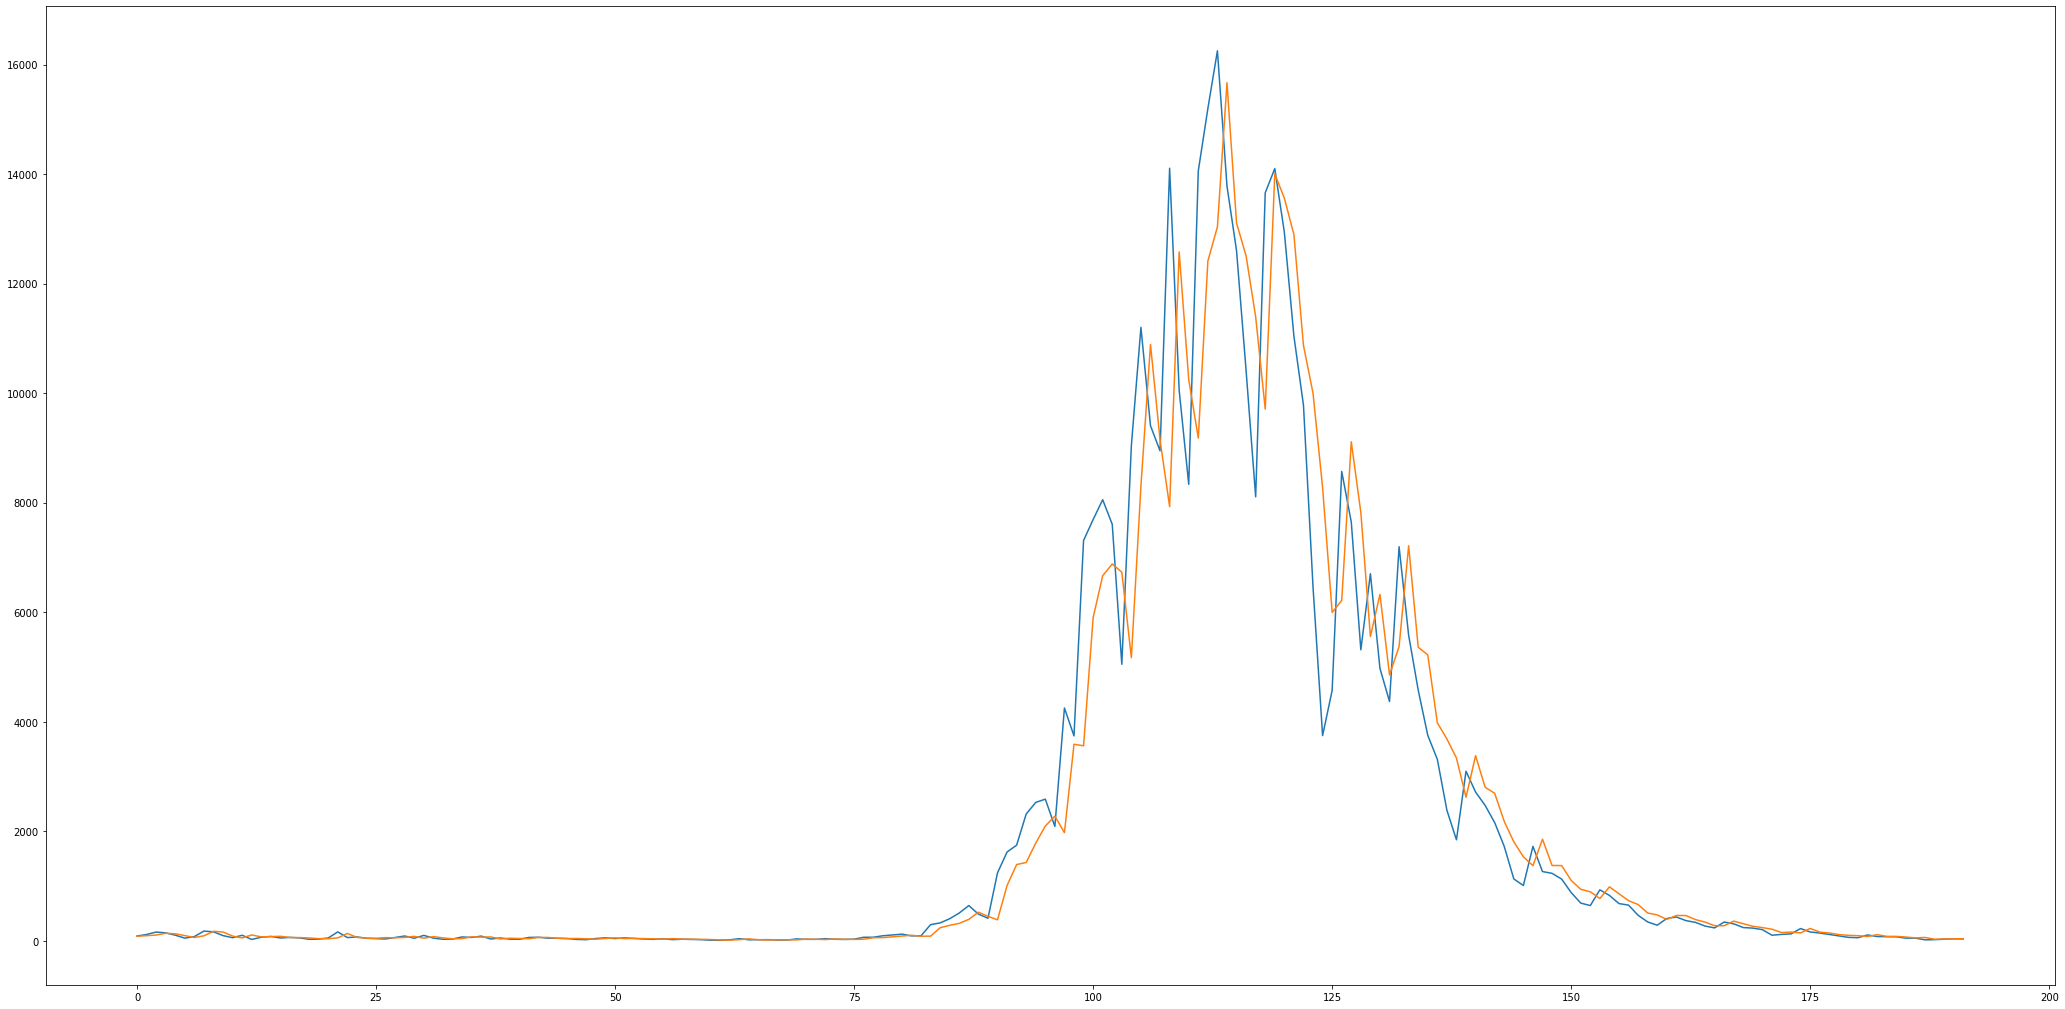

In [23]:
plt.figure(figsize=(36,18)) 
plt.plot(test_data)
plt.plot(predictions)

plt.show()

In [24]:
history

[array([20.], dtype=float32),
 array([15.], dtype=float32),
 array([2.], dtype=float32),
 array([20.], dtype=float32),
 array([6.], dtype=float32),
 array([10.], dtype=float32),
 array([76.], dtype=float32),
 array([22.], dtype=float32),
 array([12.], dtype=float32),
 array([10.], dtype=float32),
 array([29.], dtype=float32),
 array([17.], dtype=float32),
 array([59.], dtype=float32),
 array([4.], dtype=float32),
 array([30.], dtype=float32),
 array([7.], dtype=float32),
 array([42.], dtype=float32),
 array([11.], dtype=float32),
 array([50.], dtype=float32),
 array([7.], dtype=float32),
 array([8.], dtype=float32),
 array([4.], dtype=float32),
 array([18.], dtype=float32),
 array([71.], dtype=float32),
 array([18.], dtype=float32),
 array([10.], dtype=float32),
 array([34.], dtype=float32),
 array([1.], dtype=float32),
 array([20.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([32.], dtype=float32),
 array([11.], dtype=float32),
 array([179.], dtype

In [25]:
model = ARIMA(history, order=(5,1,0), seasonal_order=(0,0,0,30))
model_fit = model.fit()
output = model_fit.forecast(steps=1)
# multi-step out-of-sample forecast
start_index = len(history)
end_index = start_index + 29
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in df]
day = 1
for yhat in forecast:
	print('Day %d: %f' % (day, yhat))
	history.append(yhat)
	day += 1

# forecast = model_fit.forecast(steps=30)

Day 1: 32.658447
Day 2: 29.707584
Day 3: 27.328640
Day 4: 27.634619
Day 5: 28.855384
Day 6: 29.246840
Day 7: 29.770208
Day 8: 29.695556
Day 9: 29.199767
Day 10: 28.950232
Day 11: 28.973982
Day 12: 29.045611
Day 13: 29.180228
Day 14: 29.264362
Day 15: 29.235854
Day 16: 29.178020
Day 17: 29.143964
Day 18: 29.131293
Day 19: 29.144338
Day 20: 29.167436
Day 21: 29.178000
Day 22: 29.175773
Day 23: 29.169014
Day 24: 29.162307
Day 25: 29.159812
Day 26: 29.161935
Day 27: 29.165047
Day 28: 29.166764
Day 29: 29.166863
Day 30: 29.165848


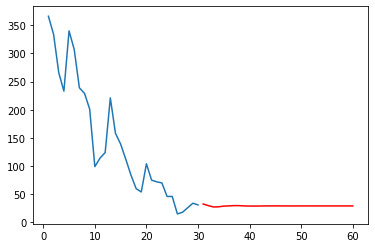

In [26]:
day_new=np.arange(1,31) # dari data 30 hari terakhir
day_pred=np.arange(31,61) #predict 30 hari kedepan

plt.plot(day_new, df[736:766])
plt.plot(day_pred, forecast, color='red')
plt.show()